In [15]:
#importing pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#allowing graphs in the program
%matplotlib inline

#importing data as data frames
df_construct=pd.read_csv('ConstructionTimeSeriesDataV2.csv')

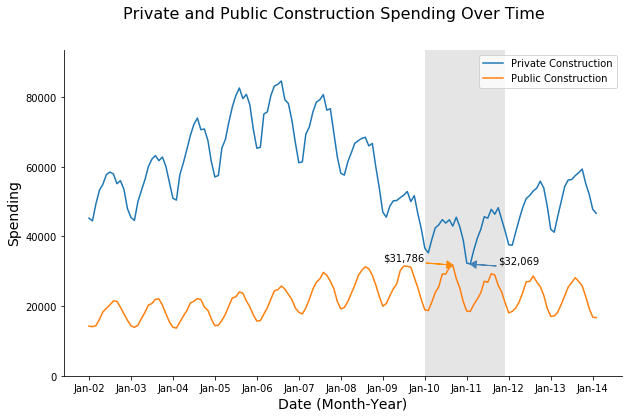

In [22]:
df_construct.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df_construct['Month-Year']))

fig,ax=plt.subplots()
ax.plot(df_construct['Month-Year'],df_construct['Private Construction'])
ax.plot(df_construct['Month-Year'],df_construct['Public Construction'])

ax.set_ylim(0,max(df_construct['Private Construction'])+9000)
ax.legend(loc=1)
ax.set_xticks(df_construct['Month-Year'][::12])
ax.set_xticklabels(df_construct['Month-Year'][::12])

fig.set_size_inches(10,6)
fig.suptitle('Private and Public Construction Spending Over Time',size='16')
ax.set_xlabel('Date (Month-Year)', size='14')
ax.set_ylabel('Spending', size='14')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvspan('Jan-10','Dec-11',facecolor='k',alpha=0.1)
plt.annotate(s="$31,786",xy=('Sep-10',31786),xytext=('Jan-09',33000),arrowprops=dict(color='darkorange', width=.1, headwidth=7.5,headlength=6))
plt.annotate(s="$32,069",xy=('Feb-11',32069),xytext=('Oct-11',32069),arrowprops=dict(color='steelblue', width=.1, headwidth=7.5,headlength=6))
plt.show()


The minimum of the private construction spending and the maximum of the public construction spending occur within a 6-month period. This could be indicative of some external factors resulting in less private and more public spending such as a shortage in the private construction work force.